In [1]:
import numpy as np
import pandas as pd

In [2]:
from prodpy import Schedule

In [39]:
np.random.seed(0)
df = pd.DataFrame({
    "date": pd.date_range("2021-01-01", periods=12, freq="D"),
    "qoil": 800 * np.exp(-0.02 * np.arange(12)) + np.random.normal(0, 5, 12),
})
df.head()

,date,qoil
0,2021-01-01,808.820262
1,2021-01-02,786.159725
2,2021-01-03,773.525241
3,2021-01-04,764.616093
4,2021-01-05,747.830867


In [5]:
# Build a Schedule from the time column (sorting enforced automatically)
sched = Schedule(df["date"])  # dtype normalized to datetime64[ns]

In [40]:
sched.series.head()

0   2021-01-01
1   2021-01-02
2   2021-01-03
3   2021-01-04
4   2021-01-05
Name: date, dtype: datetime64[ns]

In [9]:
# Elapsed time in days since the first timestamp — perfect for decline models
t_days = sched.days_since_start()  # np.ndarray[float64]

In [10]:
t_days

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11.])

In [37]:
# Keep alignment with df: same order as the sorted time column
# (If your df wasn't already sorted by date, use the returned index to align.)
df_sorted = df.loc[sched.series.index].reset_index(drop=True)
df_sorted["t_days"] = t_days

print(df_sorted.head())

        date        qoil  t_days
0 2021-01-01  808.820262     0.0
1 2021-01-02  786.159725     1.0
2 2021-01-03  773.525241     2.0
3 2021-01-04  764.616093     3.0
4 2021-01-05  747.830867     4.0


In [13]:
# 2) Using prior/later/within returning Schedule objects
left_window  = sched.prior("2021-01-05")           # dates <= 2021-01-05
right_window = sched.later("2021-01-08", inclusive=False)  # dates > 2021-01-08
mid_window   = sched.within(("2021-01-04", "2021-01-09"))

print(left_window.series.min(), left_window.series.max())
print(right_window.series.min(), right_window.series.max())
print(mid_window.series.min(), mid_window.series.max())

2021-01-01 00:00:00 2021-01-05 00:00:00
2021-01-09 00:00:00 2021-01-12 00:00:00
2021-01-04 00:00:00 2021-01-09 00:00:00


In [14]:
# 3) Nearest timestamp to an arbitrary datetime
nearest = sched.nearest("2021-01-06 12:00")
print("nearest:", nearest)

nearest: 2021-01-06 00:00:00


In [15]:
# 4) Month properties (days in month, with optional shift)
# shift=0  -> current month for each timestamp
# shift=1  -> next month for each timestamp
# shift=-1 -> previous month for each timestamp
print("days in month (this month):", sched.month_lengths().unique().tolist())
print("days in month (next month):", sched.month_lengths(shift=1).unique().tolist())

days in month (this month): [31]
days in month (next month): [28]


In [16]:
# 5) Generating schedules from ranges (e.g., for forecasting grids)
# Build a disjoint schedule sampled every 7 days
span = Schedule.get(
    ("2021-01-01", "2021-02-01"),
    ("2024-01-01", "2024-02-01"),
    freq="7D",
)
print(span.series[:5])
print("First / last:", span.mindate, span.maxdate)
print("Month lengths (span):", span.month_lengths().tolist()[:5])

0   2021-01-01
1   2021-01-08
2   2021-01-15
3   2021-01-22
4   2021-01-29
dtype: datetime64[ns]
First / last: 2021-01-01 2024-01-29
Month lengths (span): [31, 31, 31, 31, 31]


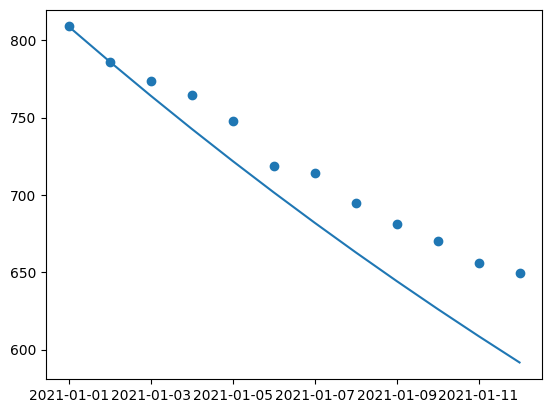

In [33]:
# 6) Applying the mask to your DataFrame and arrays for model fitting
# Suppose your decline model needs (t, q). Use the same mask from the Schedule.
cal_window = ("2021-01-01", "2021-01-02")
mask = sched.iswithin(cal_window)

q_cal = df_sorted.loc[mask, "qoil"].to_numpy()
t_cal = t_days[mask]

# Example: hand-rolled exponential fit using np.polyfit on log(q)
# (Replace this with your production Arps class.)
coef = np.polyfit(t_cal, np.log(np.clip(q_cal, 1e-12, None)), 1)
D_est = -coef[0]                    # decline rate (per day)
qi_est = float(np.exp(coef[1]))     # initial rate

# Predict over the full schedule
q_pred = qi_est * np.exp(-D_est * t_days)

df_out = df_sorted.copy()
df_out["q_pred_exp"] = q_pred

import matplotlib.pyplot as plt

plt.scatter(df_out['date'],df_out['qoil'])
plt.plot(df_out['date'],df_out['q_pred_exp'])

In [19]:
# 7) Typical wiring with your Arps implementation
# (Adjust the import and API to your own code.)
# from prodpy.decline.Arps import Arps
# arps = Arps(model="hyperbolic")  # or "exponential"/"harmonic"
# params = arps.fit(t_cal, q_cal)   # returns, e.g., (qi, Di, b)
# q_hat  = arps.predict(t_days, *params)
# df_sorted["q_hat"] = q_hat

In [20]:
# 8) Clamping a schedule to bounds (e.g., history matching window)
clamped = sched.clamp(start="2021-01-04", end="2021-01-08")
print(clamped.series)

3   2021-01-04
4   2021-01-05
5   2021-01-06
6   2021-01-07
7   2021-01-08
Name: date, dtype: datetime64[ns]


In [21]:
# 9) Inclusive rules for between checks (pandas-style semantics)
# Options: inclusive="both" (default), "left", "right", "neither"
between_both   = sched.isbetween("2021-01-03", "2021-01-05", inclusive="both")
between_left   = sched.isbetween("2021-01-03", "2021-01-05", inclusive="left")
between_right  = sched.isbetween("2021-01-03", "2021-01-05", inclusive="right")
between_none   = sched.isbetween("2021-01-03", "2021-01-05", inclusive="neither")
print(between_both.sum(), between_left.sum(), between_right.sum(), between_none.sum())

3 2 2 1


In [41]:
# 10) Using Schedule with unsorted input and preserving alignment
# Create an intentionally unsorted DataFrame
raw = pd.DataFrame({
    "date": pd.to_datetime(["2021-01-03", "2021-01-01", "2021-01-05", "2021-01-02"]),
    "qoil": [300, 500, 200, 400],
})

sched2 = Schedule(raw["date"])             # internally sorted by date
order = sched2.align_to(raw, on="date")    # index ordering that sorts by time
raw_sorted = raw.loc[order].reset_index(drop=True)
raw_sorted["t_days"] = sched2.days_since_start()
print(raw_sorted)

        date  qoil  t_days
0 2021-01-01   500     0.0
1 2021-01-02   400     1.0
2 2021-01-03   300     2.0
3 2021-01-05   200     4.0


In [42]:
# 11) Mask once, reuse everywhere (t, q, additional columns)
mask = sched.iswithin(("2021-01-02", "2021-01-06"))
sel = df_sorted.loc[mask, ["date", "qoil", "t_days"]].reset_index(drop=True)
print(sel)

        date        qoil  t_days
0 2021-01-02  786.159725     1.0
1 2021-01-03  773.525241     2.0
2 2021-01-04  764.616093     3.0
3 2021-01-05  747.830867     4.0
4 2021-01-06  718.983545     5.0


In [43]:
# 12) Forecast grid for plotting
# Build a dense future schedule based on last history date
last_day = df_sorted["date"].max()
future = Schedule.get((last_day + pd.Timedelta(days=1), last_day + pd.Timedelta(days=90)),
                      freq="D")
# Rebase future t to history t0 for continuous prediction
future_t = future.days_since(df_sorted["date"].min())
print(future.series[:3], future_t[:3])

0   2021-01-13
1   2021-01-14
2   2021-01-15
dtype: datetime64[ns] [12. 13. 14.]
